# Artificial Neural Networks for Predicting Peptide Fragmentation

## Loading modules, functions and datasets

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import pandas as pd
import numpy as np
from scipy import stats
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import initializers
from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM, Embedding
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
def normalize_predictions(preds, test, concat): 
    norms = []
    
    #max-scale intensities
    for arr in preds:
        max_intensity = np.max(arr)
        normalized_arr = arr / max_intensity
        norms.append(normalized_arr)

    norms = np.array(norms) # convert to numpy-array

    fix = []
    
    # make sure that -1 values in prediction match -1 values in test 
    for y_pred_arr, y_test_arr in zip(norms, test):
        fixed_arr = np.where((y_test_arr == -1), -1, y_pred_arr)
        fix.append(fixed_arr)

    fix = np.array(fix)

    p_fil = []
    t_fil = []
    
    # remove -1 values to not falsely boost accuracy scores
    for y_pred_arr, y_test_arr in zip(fix, test):
        mask = (y_pred_arr != -1)
        filtered_y_pred_arr = y_pred_arr[mask]
        filtered_y_test_arr = y_test_arr[mask]
        p_fil.append(filtered_y_pred_arr)
        t_fil.append(filtered_y_test_arr)
    if concat:
        t_fil = np.concatenate(t_fil) 
        p_fil = np.concatenate(p_fil)
    return[p_fil,t_fil]

In [3]:
def norm_dot_product(v1, v2):
    dot_product = np.dot(v1,v2)
    
    norm1 = np.linalg.norm(v1)
    norm2 = np.linalg.norm(v2)
    
    return dot_product/(norm1*norm2)

In [14]:
X = np.load('X_final.npy')
print(X)
print(X.shape)
print(" ")
y = np.load('y_final.npy')
print(y)
print(y.shape)

[[ 5  3  7 ... -1 -1  3]
 [ 5  3  7 ... -1 -1  3]
 [20  5 16 ... -1 -1  2]
 ...
 [25 19  1 ... -1 -1  2]
 [25 19  1 ... -1 -1  2]
 [25 19  1 ... -1 -1  2]]
(3892724, 31)
 
[[ 0.          0.04226476  0.06942312 ... -1.         -1.
  -1.        ]
 [ 0.          0.0300348   0.05937908 ... -1.         -1.
  -1.        ]
 [ 0.          0.          0.         ... -1.         -1.
  -1.        ]
 ...
 [ 0.          0.3759307   0.00947882 ... -1.         -1.
  -1.        ]
 [ 0.          0.35836761  0.00580796 ... -1.         -1.
  -1.        ]
 [ 0.          0.34606871  0.00517434 ... -1.         -1.
  -1.        ]]
(3892724, 58)


In [13]:
#for LSTM fitting and predicting, -1 has to be replaced by 0;
X[X == -1] = 0

In [15]:
#splitting the data;
X_trainBeginning, X_testEval, y_trainBeginning, y_testEval = train_test_split(X, y, test_size=0.2, shuffle=False)

In [16]:
X_trainBeginning = np.array(X_trainBeginning)
X_testEval = np.array(X_testEval)
y_trainBeginning = np.array(y_trainBeginning)
y_testEval = np.array(y_testEval)
print(X_trainBeginning.shape)
print(X_testEval.shape)
print(y_trainBeginning.shape)
print(y_testEval.shape)

(3114179, 31)
(778545, 31)
(3114179, 58)
(778545, 58)


## Models

### 1. Model with Dense layer

##### Training and evaluating:

In [18]:
model_Dense = tf.keras.models.Sequential()
model_Dense.add(tf.keras.Input(shape = (31,)))
model_Dense.add(tf.keras.layers.Dense(78, kernel_initializer='normal', activation='selu'))
model_Dense.add(tf.keras.layers.Dense(156, kernel_initializer='normal', activation='selu'))
model_Dense.add(tf.keras.layers.Dense(78, kernel_initializer='normal', activation='selu'))
model_Dense.add(tf.keras.layers.Dense(58, kernel_initializer='normal', activation='sigmoid'))

print("Output shape: ",model_Dense.output.shape)
print(model_Dense.summary())
print("Number of layers: ",len(model_Dense.layers))


Output shape:  (None, 58)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 78)                2496      
                                                                 
 dense_9 (Dense)             (None, 156)               12324     
                                                                 
 dense_10 (Dense)            (None, 78)                12246     
                                                                 
 dense_11 (Dense)            (None, 58)                4582      
                                                                 
Total params: 31648 (123.62 KB)
Trainable params: 31648 (123.62 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Number of layers:  4


In [19]:
print("Compiling Dense model: ...")
model_Dense.compile(loss='mean_squared_error', optimizer='adam')

print("Fitting Dense model: ...")
mse_scores_Dense = []
pearson_r_scores_Dense = []
norm_dot_product_scores_Dense = []

kf = KFold(n_splits=5, shuffle=False)

for train_index, test_index in kf.split(X_trainBeginning):
    X_train, X_test = X_trainBeginning[train_index], X_trainBeginning[test_index]
    y_train, y_test = y_trainBeginning[train_index], y_trainBeginning[test_index]

    model_Dense.fit(X_train, y_train, epochs=1, batch_size=60, verbose=1) 
    y_pred_Dense = model_Dense.predict(X_test)
    a_Dense,b_Dense = normalize_predictions(y_pred_Dense, y_test, True)
    
    mse_Dense = mean_squared_error(b_Dense, a_Dense)
    mse_scores_Dense.append(mse_Dense)

    pearson_r_Dense, _ = stats.pearsonr(b_Dense, a_Dense)
    pearson_r_scores_Dense.append(pearson_r_Dense)

    ndp_Dense = norm_dot_product(b_Dense, a_Dense)
    norm_dot_product_scores_Dense.append(ndp_Dense)
    
    print(f"Reults Fold:")
    print("MSE:", mse_Dense)
    print("Pearson's R:", pearson_r_Dense)
    print("norm_dot_product:", ndp_Dense)
    print()
    

# calculate and print mean metrics
mean_mse_Dense = np.mean(mse_scores_Dense)
mean_pearson_r_Dense = np.mean(pearson_r_scores_Dense)
mean_norm_dot_product_Dense = np.mean(norm_dot_product_scores_Dense)

print("Mean MSE:", mean_mse_Dense)
print("Mean Pearson's R:", mean_pearson_r_Dense)
print("Mean norm_dot_product:", mean_norm_dot_product_Dense)

Compiling Dense model: ...
Fitting Dense model: ...
19464/19464 [==============================] - 48s 2ms/step
Reults Fold:
MSE: 0.07350836981250701
Pearson's R: 0.6004826047289685
norm_dot_product: 0.7347520390454823

19464/19464 [==============================] - 41s 2ms/step
Reults Fold:
MSE: 0.06643659775911481
Pearson's R: 0.6282599962186688
norm_dot_product: 0.7512227098068808

19464/19464 [==============================] - 40s 2ms/step
Reults Fold:
MSE: 0.05876953578768187
Pearson's R: 0.649611373839489
norm_dot_product: 0.7643356213995567

19464/19464 [==============================] - 38s 2ms/step
Reults Fold:
MSE: 0.05737651477764087
Pearson's R: 0.655397649058107
norm_dot_product: 0.7674204209724986

19464/19464 [==============================] - 43s 2ms/step
Reults Fold:
MSE: 0.05470118611776058
Pearson's R: 0.6693652355833952
norm_dot_product: 0.7761320283986217

Mean MSE: 0.062158440850941035
Mean Pearson's R: 0.6406233718857257
Mean norm_dot_product: 0.758772563924608


### Model with Bi-LSTM Layer:

In [17]:
modelLstm = tf.keras.models.Sequential()
modelLstm.add(tf.keras.Input(shape = (31,)))
modelLstm.add(tf.keras.layers.Embedding(3114179, 2, input_length = 31))
modelLstm.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)))
modelLstm.add(tf.keras.layers.Dense(58,activation='selu'))

print("Output shape: ",modelLstm.output.shape)
print(modelLstm.summary())
print("Number of layers: ",len(modelLstm.layers))

Output shape:  (None, 58)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 31, 2)             6228358   
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                8960      
 onal)                                                           
                                                                 
 dense_9 (Dense)             (None, 58)                3770      
                                                                 
Total params: 6241088 (23.81 MB)
Trainable params: 6241088 (23.81 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Number of layers:  3


In [18]:
print("Compiling model with Bi-LSTM layer: ...")
modelLstm.compile(loss='mean_squared_error', optimizer='adam')

print("Fitting and evaluating model with Bi-LSTM layer: ...")

mse_scores_Lstm = []
pearson_r_scores_Lstm = []
norm_dot_product_scores_Lstm = []

kf = KFold(n_splits=5, shuffle=False)

for train_index, test_index in kf.split(X_trainBeginning):
    X_train, X_test = X_trainBeginning[train_index], X_trainBeginning[test_index]
    y_train, y_test = y_trainBeginning[train_index], y_trainBeginning[test_index]

    modelLstm.fit(X_train, y_train, epochs=1, batch_size=60, verbose=1 ) 
    y_pred_Lstm = modelLstm.predict(X_test)
    a_Lstm,b_Lstm = normalize_predictions(y_pred_Lstm, y_test, True)
    
    mse_Lstm = mean_squared_error(b_Lstm, a_Lstm)
    mse_scores_Lstm.append(mse_Lstm)

    pearson_r_Lstm, _ = stats.pearsonr(b_Lstm, a_Lstm)
    pearson_r_scores_Lstm.append(pearson_r_Lstm)

    ndp_Lstm = norm_dot_product(b_Lstm, a_Lstm)
    norm_dot_product_scores_Lstm.append(ndp_Lstm)
    
    print("Reults Fold:")
    print("MSE:", mse_Lstm)
    print("Pearson's R:", pearson_r_Lstm)
    print("norm_dot_product:", ndp_Lstm)
    print()


# calculate and print mean metrics
mean_mse_Lstm = np.mean(mse_scores_Lstm)
mean_pearson_r_Lstm = np.mean(pearson_r_scores_Lstm)
mean_norm_dot_product_Lstm = np.mean(norm_dot_product_scores_Lstm)

print("Mean MSE:", mean_mse_Lstm)
print("Mean Pearson's R:", mean_pearson_r_Lstm)
print("Mean norm_dot_product:", mean_norm_dot_product_Lstm)

Compiling model with Bi-LSTM layer: ...
Fitting and evaluating model with Bi-LSTM layer: ...
19464/19464 [==============================] - 108s 5ms/step
Reults Fold:
MSE: 0.0667111912912925
Pearson's R: 0.644673686063528
norm_dot_product: 0.761664947075082

19464/19464 [==============================] - 100s 5ms/step
Reults Fold:
MSE: 0.04383915178271773
Pearson's R: 0.7072534712901458
norm_dot_product: 0.8002754253697978

19464/19464 [==============================] - 146s 7ms/step
Reults Fold:
MSE: 0.04066997533162365
Pearson's R: 0.7382585672612071
norm_dot_product: 0.8203475783233155

19464/19464 [==============================] - 208s 11ms/step
Reults Fold:
MSE: 0.03539809388878547
Pearson's R: 0.7556133906150639
norm_dot_product: 0.8314952707006502

19464/19464 [==============================] - 106s 5ms/step
Reults Fold:
MSE: 0.03436475229769275
Pearson's R: 0.7652603077622807
norm_dot_product: 0.8379880688181415

Mean MSE: 0.04419663291842242
Mean Pearson's R: 0.72221188459844

## Graphs

#### Dense Cross Validation Graph

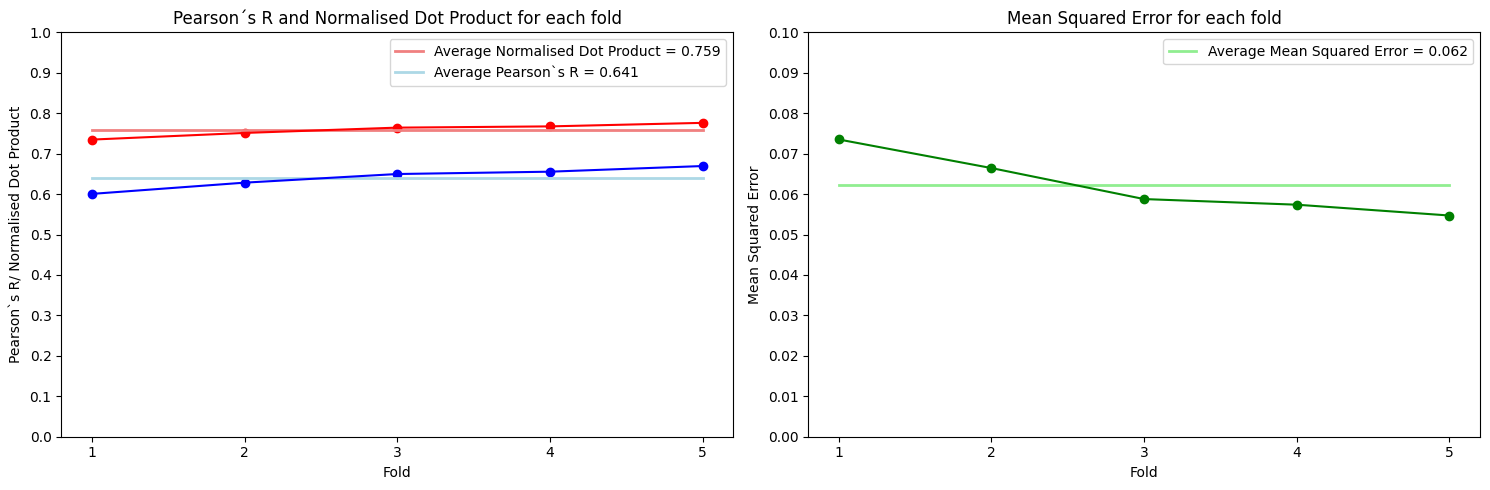

In [20]:
x = np.array([1,2,3,4,5])

diag_mse_Dense = []
diag_pR_Dense=[]
diag_ndp_Dense=[]
for i in range (5):
    diag_mse_Dense.append(mse_scores_Dense[i])
    diag_pR_Dense.append(pearson_r_scores_Dense[i])
    diag_ndp_Dense.append(norm_dot_product_scores_Dense[i])

line_mse_Dense = []
line_pR_Dense = []
line_ndp_Dense = []
for j in range (5):
    line_mse_Dense.append(mean_mse_Dense)
    line_pR_Dense.append(mean_pearson_r_Dense)
    line_ndp_Dense.append(mean_norm_dot_product_Dense)


# make three subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# plot Pearson's R and NDP for each fold
axes[0].plot(x,line_ndp_Dense,color='lightcoral', linewidth=2, label='Average Normalised Dot Product = {:.3f}'.format(mean_norm_dot_product_Dense))
axes[0].scatter(x,diag_ndp_Dense, color='red')
axes[0].plot(x,diag_ndp_Dense, color='red')

axes[0].plot(x,line_pR_Dense,color='lightblue', linewidth=2, label='Average Pearson`s R = {:.3f}'.format(mean_pearson_r_Dense))
axes[0].scatter(x, diag_pR_Dense, color='blue')
axes[0].plot(x, diag_pR_Dense, color='blue')

axes[0].set_title('Pearson´s R and Normalised Dot Product for each fold')
axes[0].set_xlabel('Fold')
axes[0].set_ylabel('Pearson`s R/ Normalised Dot Product')
axes[0].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
axes[0].set_ylim(0.0, 1.0)
axes[0].set_yticks(np.arange(0, 1.1, 0.1))
axes[0].set_yticklabels(['0.0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1.0'])

# plot mse for each fold
axes[1].plot(x,line_mse_Dense,color='lightgreen', linewidth=2, label='Average Mean Squared Error = {:.3f}'.format(mean_mse_Dense))
axes[1].scatter(x, diag_mse_Dense, color='green')
axes[1].plot(x, diag_mse_Dense, color='green')
axes[1].set_title('Mean Squared Error for each fold')
axes[1].set_xlabel('Fold')
axes[1].set_ylabel('Mean Squared Error')
axes[1].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
axes[1].set_ylim(0.00, 0.10)
axes[1].set_yticks(np.arange(0.00, 0.11, 0.01))

# legend
for ax in axes:
    ax.legend()

plt.tight_layout()
plt.show()

#### Bi-LSTM Cross Validation Graph

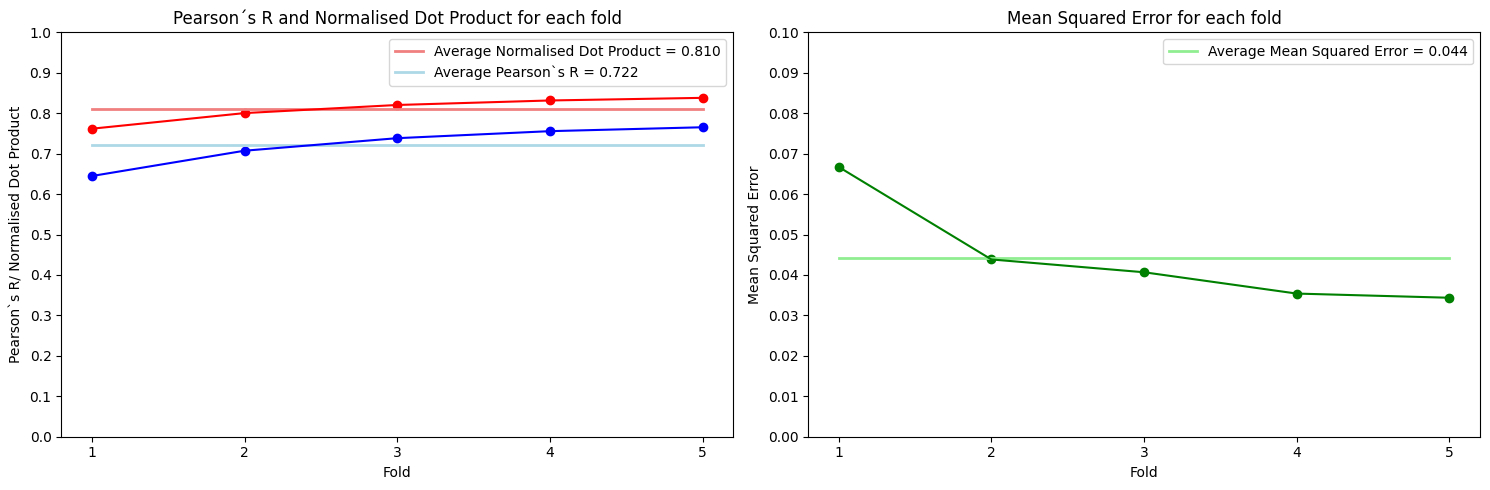

In [32]:
x = np.array([1,2,3,4,5])

diag_mse_Lstm = []
diag_pR_Lstm=[]
diag_ndp_Lstm=[]
for i in range (5):
    diag_mse_Lstm.append(mse_scores_Lstm[i])
    diag_pR_Lstm.append(pearson_r_scores_Lstm[i])
    diag_ndp_Lstm.append(norm_dot_product_scores_Lstm[i])

line_mse_Lstm = []
line_pR_Lstm = []
line_ndp_Lstm = []
for j in range (5):
    line_mse_Lstm.append(mean_mse_Lstm)
    line_pR_Lstm.append(mean_pearson_r_Lstm)
    line_ndp_Lstm.append(mean_norm_dot_product_Lstm)


# make three subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# plot Pearson's R and NDP for each fold
axes[0].plot(x,line_ndp_Lstm,color='lightcoral', linewidth=2, label='Average Normalised Dot Product = {:.3f}'.format(mean_norm_dot_product_Lstm))
axes[0].scatter(x,diag_ndp_Lstm, color='red')
axes[0].plot(x,diag_ndp_Lstm, color='red')
axes[0].plot(x,line_pR_Lstm,color='lightblue', linewidth=2, label='Average Pearson`s R = {:.3f}'.format(mean_pearson_r_Lstm))
axes[0].scatter(x, diag_pR_Lstm, color='blue')
axes[0].plot(x, diag_pR_Lstm, color='blue')
axes[0].set_title('Pearson´s R and Normalised Dot Product for each fold')
axes[0].set_xlabel('Fold')
axes[0].set_ylabel('Pearson`s R/ Normalised Dot Product')
axes[0].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
axes[0].set_ylim(0.0, 1.0)
axes[0].set_yticks(np.arange(0, 1.1, 0.1))
axes[0].set_yticklabels(['0.0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1.0'])

# plot mse for each fold
axes[1].plot(x,line_mse_Lstm,color='lightgreen', linewidth=2, label='Average Mean Squared Error = {:.3f}'.format(mean_mse_Lstm))
axes[1].scatter(x, diag_mse_Lstm, color='green')
axes[1].plot(x, diag_mse_Lstm, color='green')
axes[1].set_title('Mean Squared Error for each fold')
axes[1].set_xlabel('Fold')
axes[1].set_ylabel('Mean Squared Error')
axes[1].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
axes[1].set_ylim(0.00, 0.10)
axes[1].set_yticks(np.arange(0.00, 0.11, 0.01))

# legend
for ax in axes:
    ax.legend()

plt.tight_layout()
plt.show()